In [319]:
!pip install category_encoders
!pip install pycaret

In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

# data prep
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler,OrdinalEncoder
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV




## Business Problem Understanding

**Context** 


Daegu adalah kota metropolitan terbesar keempat di Korea Selatan. Daegu menjadi motor perekonomian Korea pada periode 1960an-1980an yang terkenal dengan industri elektroniknya. Saat ini Daegu fokus pada pengembangan industri fashion dan teknologi. Selain itu, kota ini juga menawarkan banyak wisata dan budaya yang menarik seperti Menara Daegu 83, pusat kebudayaan ARC, Patung Gatbawi dan yang lainnya. Dengan banyak nya industri dan tempat wisata tentunya kota ini memiliki banyak penduduknya. Pada tahun 2023 diperkirakan jumlah populasi mencapai 2.180.997 jiwa.

Kepadatan penduduk dan banyaknya industri maupun tempat wisata membuat lahan kosong di Daegu semakin menipis. Sehingga penggunaan lahan kosong harus dilakukan dengan cermat. Salah satunya dengan membuat hunian yang dapat menampung banyak penduduk dengan lahan yang kecil misalnya Apartment. Ini adalah suatu inovasi yang bagus dan ternyata pada tahun 2023 terdapat 36.000 keluarga yang memutuskan tinggal di Apartment. Tentunya ini menjadi peluang bisnis yang bagus untuk perusahaan agen real estate


**Problem Statement :**
Permintaan yang tinggi terhadap pembelian apartment membuat perusahan agen property saling bersaing dalam memberikan penawaran terbaik kepada konsumen. Untuk meningkatkan penjualan banyak faktor yang harus diperhatikan, salah satu nya adalah harga sewa ataupun harga apartment. Beberapa penelitian menyebutkan harga mempengaruhi konsumen untuk memutuskan menyewa/membeli property (misalnya dalam jurnal https://ejournal.urindo.ac.id/index.php/administrasimanajemen/article/view/2108)

Penentuan harga ini sangat krusial dan harus dilakukan dengan bijaksana. Untuk itu dalan analisis ini akan dilakukan prediksi harga dengan menggunakan Machine Learning dengan beberapa feature yang diperoleh dari data Daegu Apartment


**Goals :**

Sebelumnya perusahaan sudah membuat rule based system untuk prediksi harga apartment dengan MAE Score 113.722 (dalam won). Error yang diperoleh ini sangat tinggi yang dapat menyebabkan kerugian yang besar pada perusahaan baik dari segi demand dan profit

Maka berdasarkan permasalahan tersebut, perusahaan agen real estate dapat menentukan harga yang kompetitif dengan apartment dan fasilitas yang ditawarkan. Dan juga, perusahaan dapat mengetahui apa/faktor/variabel apa yang membuat konsumen tertarik menyewa/membeli apartment. Hal ini akan menjadi sangat berguna pada perusahaan ketika ingin membuat planning pembagunan apartment di kemudian hari.


**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan penawaran apartment dari beberapa perusahaan real estate

Kemudian kita akan membangun model prediksi yang akan membantu perusahaan untuk dapat memprediksi harga apartment yang kompetitif

**Metric Evaluation**

Dalam model prediksi, terdapat beberapa metrik yang dapat digunakan untuk mengevaluasi model yaitu  Mean Absolute Error (MAE), Root Mean Square Error(RMSE), Absolute Percentage Error (MAPE) dan Mean Squared Error (MSE). Dalam modelling ini MSE tidak akan digunakan karena metriks sulit untuk diintepretasikan dan di sisi lain RMSE dapat merepresentasikan metriks ini.

Berikut adalah penjelasan dari masing-masing metriks yang akan digunakan dalam model ini

| Metrics | Keterangan |
|--------|------------------------|
| RMSE (Root Mean Square Error) | - RMSE memberikan penilaian terhadap kesalahan prediksi model rata-rata. <br> - RMSE sangat sensitif terhadap outlier karena ia mengkuadratkan kesalahan. <br> - Cocok untuk skenario di mana kesalahan besar dalam prediksi harus dihindari. |
| MAE (Mean Absolute Error) | - MAE mengukur rata-rata kesalahan absolut antara prediksi dan nilai aktual. <br> - Lebih tangguh terhadap outlier daripada RMSE. <br> - Memberikan penilaian yang mudah ditafsirkan terhadap kinerja rata-rata model.
| MAPE (Mean Absolute Percentage Error) | - MAPE mengukur kesalahan prediksi sebagai persentase dari nilai sebenarnya. <br> - Memudahkan penafsiran kesalahan sebagai persentase, yang intuitif untuk pemahaman bisnis. <br> - Memungkinkan perbandingan akurasi antara model atau prediksi pada skala yang berbeda. |

Berdasarkan tabel di atas karena dalam data yang akan digunakan terdapat  outliers maka metrics evalution utama yang akan digunakan dalam modelling ini adalah MAE karena MAE lebih robust terhadap outliers


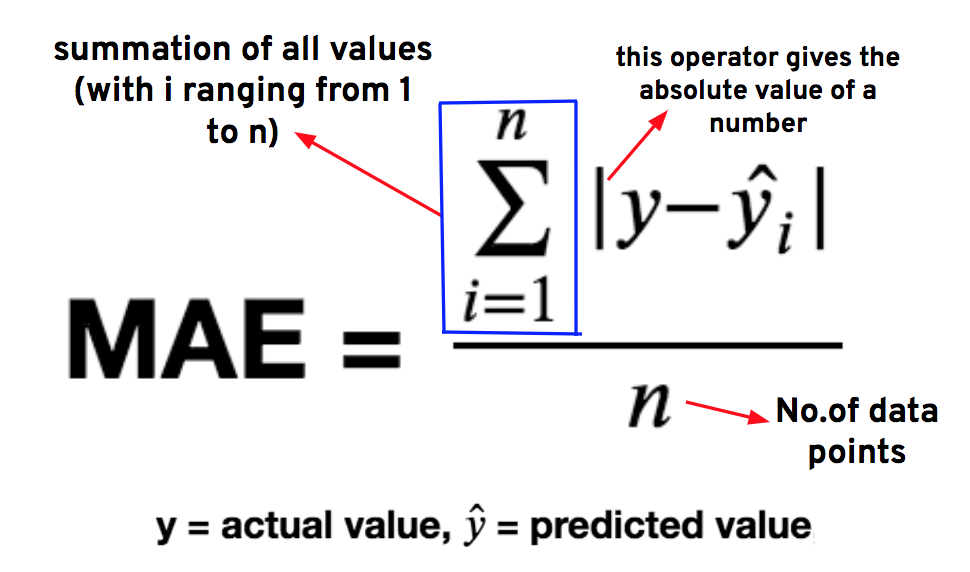

# Data Understanding

In [321]:
df = pd.read_csv('data_daegu_apartment.csv')
#df.drop(columns = 'Unnamed: 0', inplace = True)
df

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


## Penjelasan setiap variable (Data Dictionary)

|kolom | Penjelasan |
|---- | ---- |
| HallwayType | Tipe Apartment|
| TimeToSubway | Waktu yang dibutuhkan ke subway terdekat dari Apartment|
| SubwayStation | Stasiun Subway terdekat dari Apartment |
| N_FacilitiesNearBy(ETC) | Jumlah fasilitas di sekitar Apartment |
| N_FacilitiesNearBy(PublicOffice) | Jumlah fasilitas kantor publik di sekitar Apartment |
| N_SchoolNearBy(University) | Jumlah universitas/kampus yang ada di dekat Apartment |
| N_Parkinglot(Basement) | Jumlah tempat parkir |
| YearBuilt | Tahun Apartment dibangun |
| N_FacilitiesInApt | Jumlah fasilitas yang ada di apartment |
| Size(sqft) | Luas Apartment (dalam square feet) |
| SalePrice | Harga Apartment (dalam Won) |

## Missing Values

In [322]:
# Jumlah data kosong (NaN) untuk setiap variable
df.isnull().sum()

HallwayType                         0
TimeToSubway                        0
SubwayStation                       0
N_FacilitiesNearBy(ETC)             0
N_FacilitiesNearBy(PublicOffice)    0
N_SchoolNearBy(University)          0
N_Parkinglot(Basement)              0
YearBuilt                           0
N_FacilitiesInApt                   0
Size(sqf)                           0
SalePrice                           0
dtype: int64

In [323]:
# Agar lebih "cantik" dibuat dataframe
missing = pd.DataFrame({'jumlah':df.isnull().sum().sort_values(ascending = False)})
missing

,jumlah
HallwayType,0
TimeToSubway,0
SubwayStation,0
N_FacilitiesNearBy(ETC),0
N_FacilitiesNearBy(PublicOffice),0
N_SchoolNearBy(University),0
N_Parkinglot(Basement),0
YearBuilt,0
N_FacilitiesInApt,0
Size(sqf),0


Dalam data Daegu Apartment tidak ditemukan missing values di setiap kolom. Sehingga tidak memerlukan handling missing values

In [324]:
total_baris_data = len(df)
missing['persentase %'] = round((missing['jumlah']/total_baris_data)*100,2)
missing

,jumlah,persentase %
HallwayType,0,0.0
TimeToSubway,0,0.0
SubwayStation,0,0.0
N_FacilitiesNearBy(ETC),0,0.0
N_FacilitiesNearBy(PublicOffice),0,0.0
N_SchoolNearBy(University),0,0.0
N_Parkinglot(Basement),0,0.0
YearBuilt,0,0.0
N_FacilitiesInApt,0,0.0
Size(sqf),0,0.0


<Axes: >

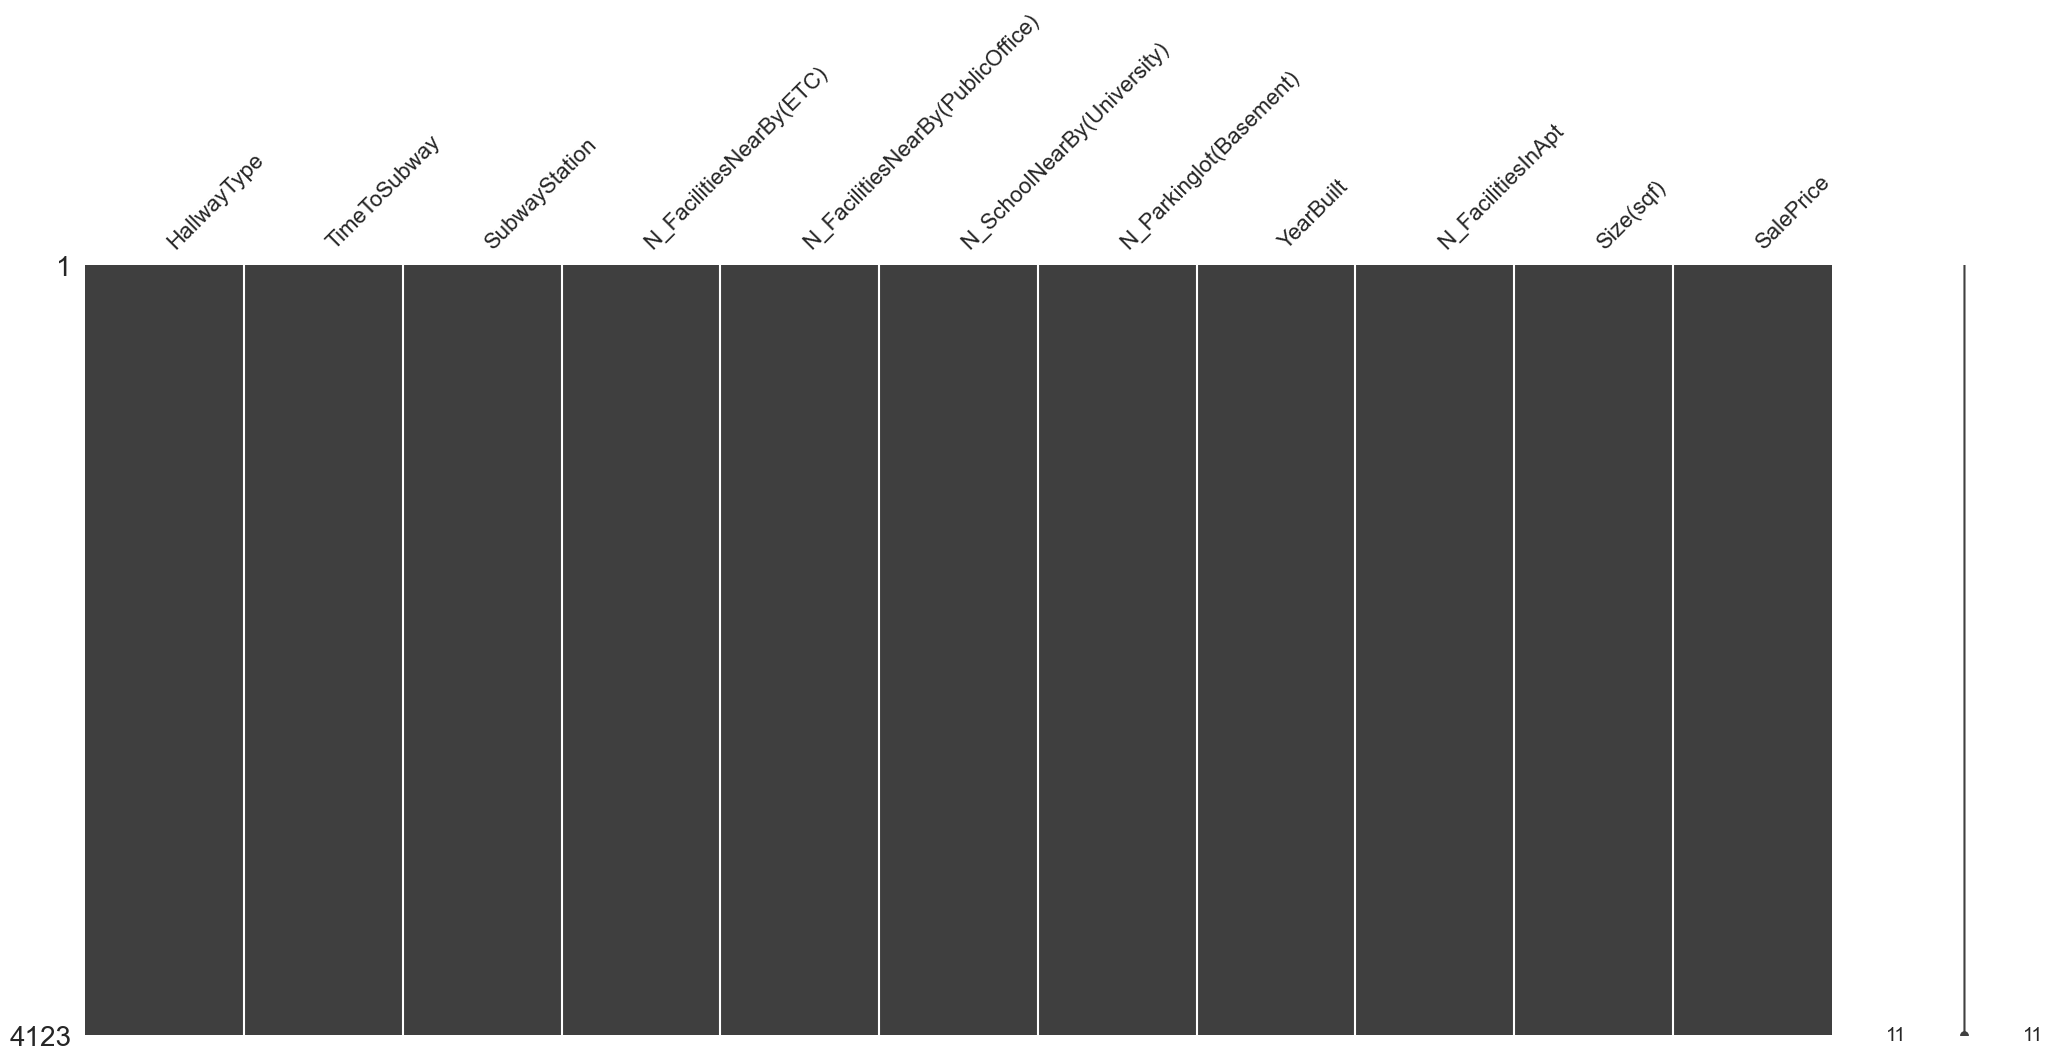

In [325]:
import missingno

# Hubungan antar missing values secara visualisasi
missingno.matrix(df)

## Data Duplikat

In [326]:
# jumlah yang duplikat
df.duplicated().sum()

1422

In [327]:
# mendrop data dupliat
df.drop_duplicates(inplace = True)

Terdapat 1422 baris data yang duplikat dan handlingnya hanya di drop saja

## Variable Numerik

### Statistika Deskriptif

In [328]:
# Statistika dekriptif
df.describe() # OTOMATIS hanya mengambil yang numerik

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,1.890411,4.027027,2.680489,533.746390,2002.358386,5.713439,984.028878,229511.365790
std,2.153168,1.887486,1.504470,418.224859,9.151949,2.386552,391.982619,105079.891321
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,181.000000,1993.000000,4.000000,743.000000,153539.000000
50%,1.000000,4.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,221238.000000
75%,5.000000,5.000000,4.000000,798.000000,2007.000000,7.000000,1167.000000,300884.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000


### Distribusi Data

In [329]:
len(df.select_dtypes(include = 'number').columns)

8

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

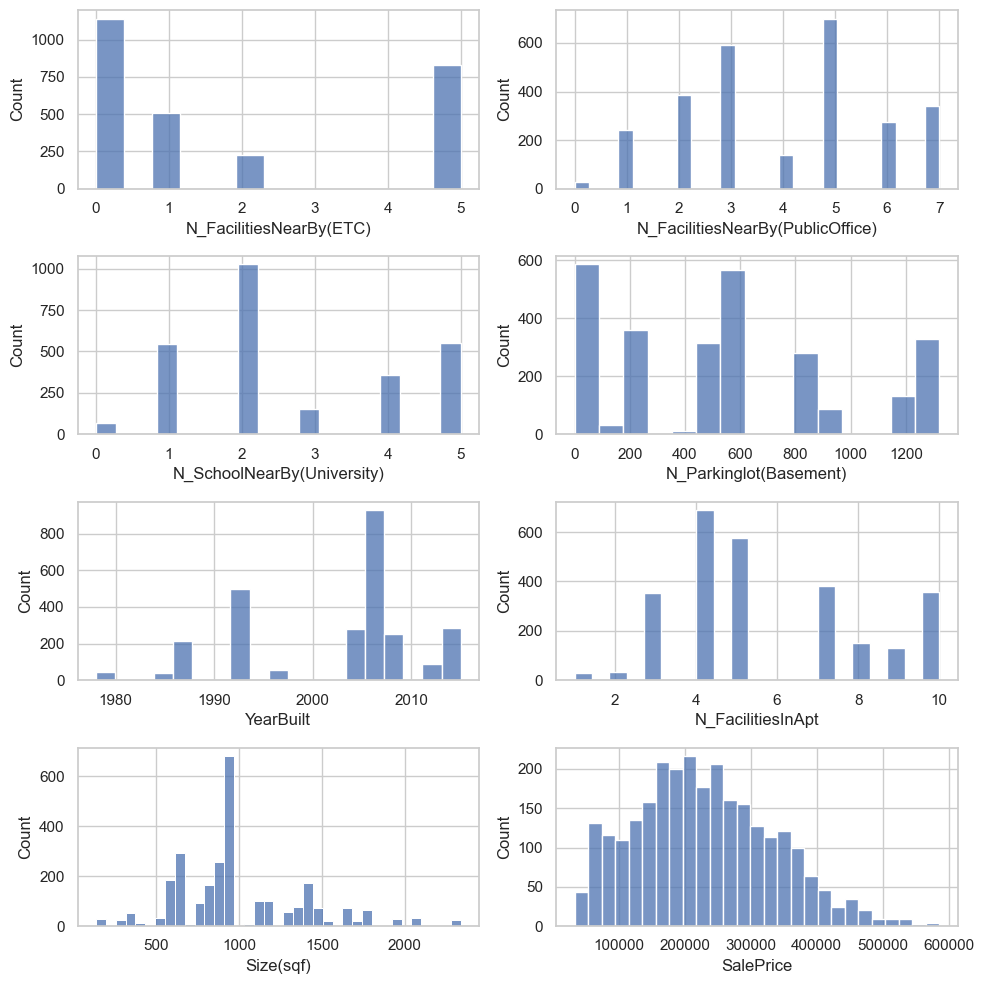

In [330]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.histplot(df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

### Outliers

#### Boxplot

Kalau di modul 2, outliers dipertimbangkan juga mengenai kontekstualnya (tidak selalu di drop). Di modul 3 juga sama, tetapi ditambah dengan nanti dilakukan eksperimen untuk dibandingkan performa modelnya pada data yg dihapus seluruh outliers menurut IQR dan tidak dihapus

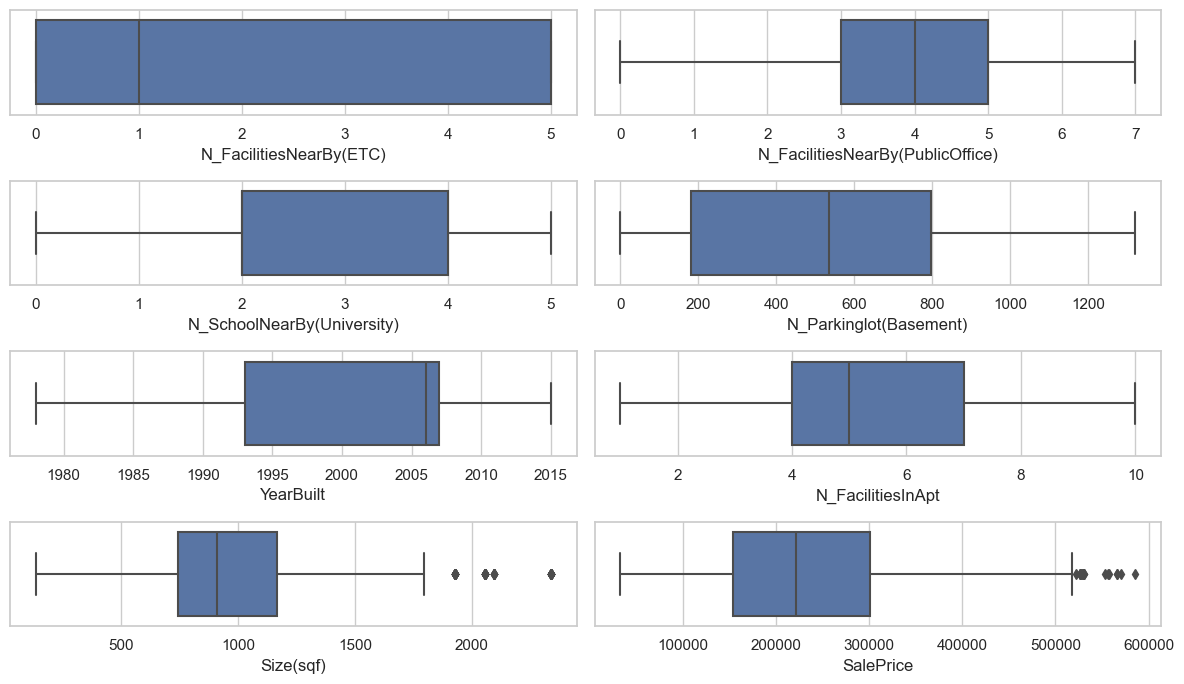

In [331]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (12,7))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

#### Outliers berdasarkan IQR

In [332]:
list_jumlah_outliers = []
for setiap_kolom in numerik.columns:
    q3 = numerik.describe()[setiap_kolom]['75%']
    q1 = numerik.describe()[setiap_kolom]['25%']
    iqr = q3 - q1
    whis = 1.5 * iqr
    upper_bound = q3 + whis
    lower_bound = q1 - whis

    jumlah_outliers = len(numerik[(numerik[setiap_kolom] > upper_bound) | (numerik[setiap_kolom] < lower_bound)])
    list_jumlah_outliers.append(jumlah_outliers)

outliers=pd.DataFrame({
                'kolom': numerik.columns,
                'jumlah_outliers': list_jumlah_outliers
                })
outliers


,kolom,jumlah_outliers
0,N_FacilitiesNearBy(ETC),0
1,N_FacilitiesNearBy(PublicOffice),0
2,N_SchoolNearBy(University),0
3,N_Parkinglot(Basement),0
4,YearBuilt,0
5,N_FacilitiesInApt,0
6,Size(sqf),84
7,SalePrice,17


In [333]:
outliers['Percentage outliers']=round((outliers['jumlah_outliers']/len(df))*100,2)
print(outliers)
print('\n')
Max_Size=df['Size(sqf)'].max()
print(f'Size(sqf) maksimal: {Max_Size}')
Max_Sale=df['SalePrice'].max()
print(f'SalePrice maksimal: {Max_Sale}')


                              kolom  jumlah_outliers  Percentage outliers
0           N_FacilitiesNearBy(ETC)                0                 0.00
1  N_FacilitiesNearBy(PublicOffice)                0                 0.00
2        N_SchoolNearBy(University)                0                 0.00
3            N_Parkinglot(Basement)                0                 0.00
4                         YearBuilt                0                 0.00
5                 N_FacilitiesInApt                0                 0.00
6                         Size(sqf)               84                 3.11
7                         SalePrice               17                 0.63


Size(sqf) maksimal: 2337
SalePrice maksimal: 585840


Terdapat temuan penting terkait outlier pada dua kolom, yaitu SalePrice dan Size. Pada kolom SalePrice ditemukan 17 outlier data yang setara dengan 0,63% dari total data. Walaupun jumlahnya relatif kecil diputuskan untuk tidak  menghapus data ini karena dianggap representatif dan bukan merupakan kesalahan input.

Sementara itu, pada kolom Size ditemukan 84 outlier yang mewakili 3,11% dari total data, dengan nilai maksimum 2337 sqf. Meskipun jumlahnya lebih besar, rentang nilai ini tidak terlalu jauh dari data lainnya. Berdasarkan pengetahuan domain, ukuran unit apartemen hingga 2335 sqf masih dianggap wajar. Oleh karena itu, diputuskan untuk mempertahankan outlier ini pada kolom Size.

Namun dalam salah satu experiment model akan dilakukan pengahapusan outliers untuk melihat apakah model yang dihasilkan lebih atau tidak

### Korelasi

<Axes: >

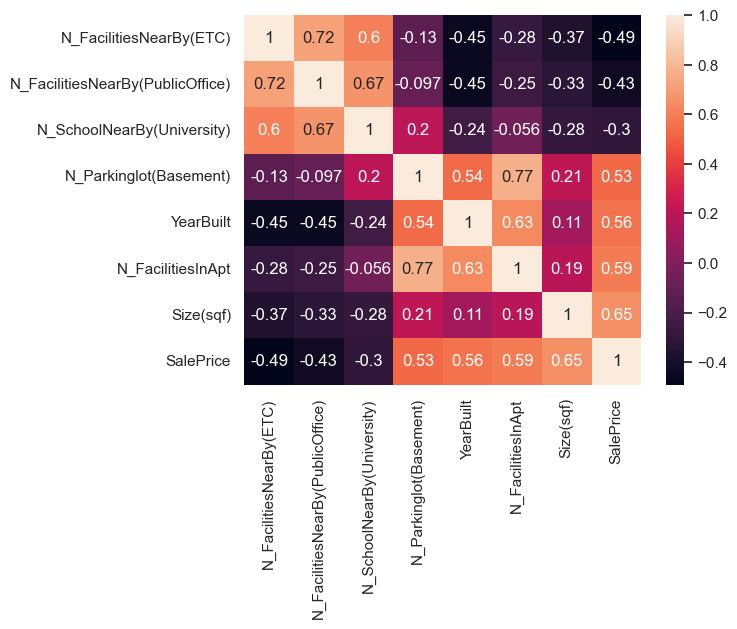

In [334]:
sns.heatmap(numerik.corr(method = 'spearman'), annot = True)

Insights: Diperoleh bahwa hampir semua fitur memiliki korelasi yang cukup tinggi dengan beberapa fitur lainnya. Oleh karena itu pada step berikut akan dicari nilai VIF untuk melakukan feature selection


### Multikolineartias dengan VIF

In [335]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# buat function
def calc_vif(x):
    # dataframe kosong
    vif = pd.DataFrame()
    vif['variables'] = x.columns
    # menghitung vig untuk setiap kolom nya
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif


In [336]:
df['SalePrice']

0       346017
1       150442
2        61946
3       165486
4       311504
         ...  
4116    290265
4117    345132
4118    323008
4119    242477
4121     73451
Name: SalePrice, Length: 2701, dtype: int64

In [337]:
calc_vif(numerik.drop(columns = ['SalePrice'])).sort_values(by = 'VIF', ascending = False)

,variables,VIF
4,YearBuilt,30.259604
5,N_FacilitiesInApt,26.112948
2,N_SchoolNearBy(University),16.257819
1,N_FacilitiesNearBy(PublicOffice),13.896514
3,N_Parkinglot(Basement),11.266549
6,Size(sqf),8.666827
0,N_FacilitiesNearBy(ETC),5.975305


In [338]:
calc_vif(numerik.drop(columns = ['SalePrice','YearBuilt'])).sort_values(by = 'VIF', ascending = False)

,variables,VIF
4,N_FacilitiesInApt,15.378934
2,N_SchoolNearBy(University),14.903227
1,N_FacilitiesNearBy(PublicOffice),12.262488
3,N_Parkinglot(Basement),8.666067
0,N_FacilitiesNearBy(ETC),5.789587
5,Size(sqf),5.406036


In [339]:
calc_vif(numerik.drop(columns = ['SalePrice','YearBuilt','N_FacilitiesInApt'])).sort_values(by = 'VIF', ascending = False)

,variables,VIF
2,N_SchoolNearBy(University),14.828710
1,N_FacilitiesNearBy(PublicOffice),10.471698
0,N_FacilitiesNearBy(ETC),5.649731
4,Size(sqf),4.504262
3,N_Parkinglot(Basement),3.092136


In [340]:
calc_vif(numerik.drop(columns = ['SalePrice','YearBuilt','N_FacilitiesInApt','N_SchoolNearBy(University)'])).sort_values(by = 'VIF', ascending = False)

,variables,VIF
1,N_FacilitiesNearBy(PublicOffice),7.214224
3,Size(sqf),4.424279
0,N_FacilitiesNearBy(ETC),3.725671
2,N_Parkinglot(Basement),2.685730


Terdapat beberapa feature yang mengalami Multikolinearitas yang ekstrem yaitu YearBuilt, N_FacilitiesInApt dan N_SchoolNearBy(University). Namun sementara feature-feature ini akan tetap dipertahankan dan nanti dalam salah satu ekperimen akan dihapus untuk melihat perbedaan akurasi model antara mempertahankan dan menghapus.

## Variabel Kategorik

### Describe

In [341]:
df.describe(include = 'object')

,HallwayType,TimeToSubway,SubwayStation
count,2701,2701,2701
unique,3,5,8
top,terraced,0-5min,Myung-duk
freq,1667,1248,709


### Unique Values

In [342]:
kategorik = df.select_dtypes(include = 'object')
kategorik.nunique()

HallwayType      3
TimeToSubway     5
SubwayStation    8
dtype: int64

In [343]:
# Menghitung frekuensi unique values fitur kategorik
list_unique_val = []
list_frequency_unique = []

for column in kategorik.columns:
    unique_val = kategorik[column].unique()
    list_unique_val.extend((unique_val))
    for setiap_unique in unique_val:
        frequency_unique = round(len(kategorik[kategorik[column] == setiap_unique])/len(kategorik)*100,2)
        list_frequency_unique.append(frequency_unique)

# Membuat dataframe distribusi Unique Values
Fitur=['HallwayType','','','TimeToSubway','','','','','SubwayStation','','','','','','','']

Dist_Unique=pd.DataFrame({
                'Fitur':Fitur,
                'Unique Values': list_unique_val,
                'Frequency':list_frequency_unique
               })
Dist_Unique

,Fitur,Unique Values,Frequency
0,HallwayType,terraced,61.72
1,,mixed,25.84
2,,corridor,12.44
3,TimeToSubway,0-5min,46.21
4,,10min~15min,16.07
5,,15min~20min,15.48
6,,5min~10min,18.55
7,,no_bus_stop_nearby,3.70
8,SubwayStation,Kyungbuk_uni_hospital,25.62
9,,Chil-sung-market,2.41


### Value Counts

c:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


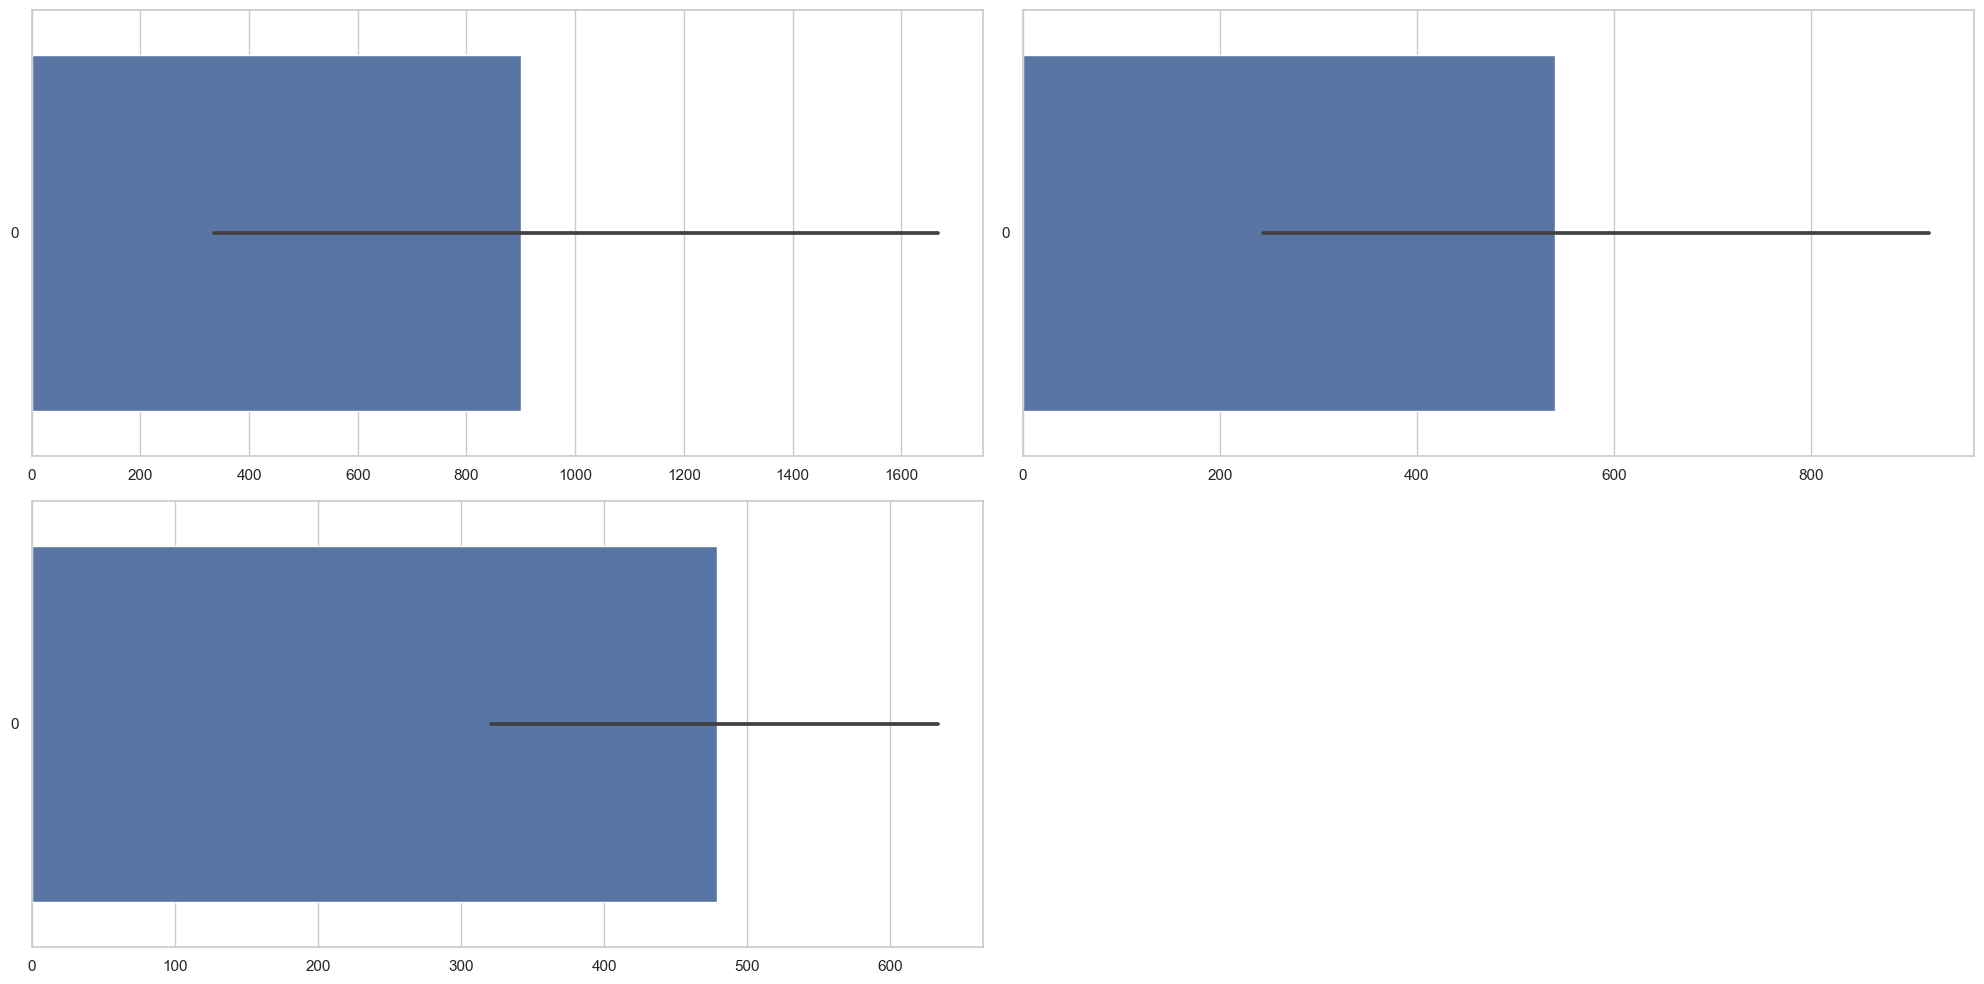

In [344]:
# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (20,10)) # (horizontal, vertikal)

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in kategorik.columns: # kategorik.columns = nama-nama kolom dalam list
    plt.subplot(2,2,posisi)
    sns.barplot(df[setiap_kolom].value_counts().head(5), orient = 'h')
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

# Data Cleaning

Dalam contoh ini kita skip saja. Tapi dalam praktik nya, sama seperti modul 2, dibersihkan satu persatu untuk setiap kolom nya

# EDA (Exploratory Data Analysis)


### Data Distribution

EDA bertujuan untuk mendapatkan gambaran tentang karakteristik umum properti yang tersedia di pasar real estat Daegu, termasuk size, price, year of construction, aspek lainnya.

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

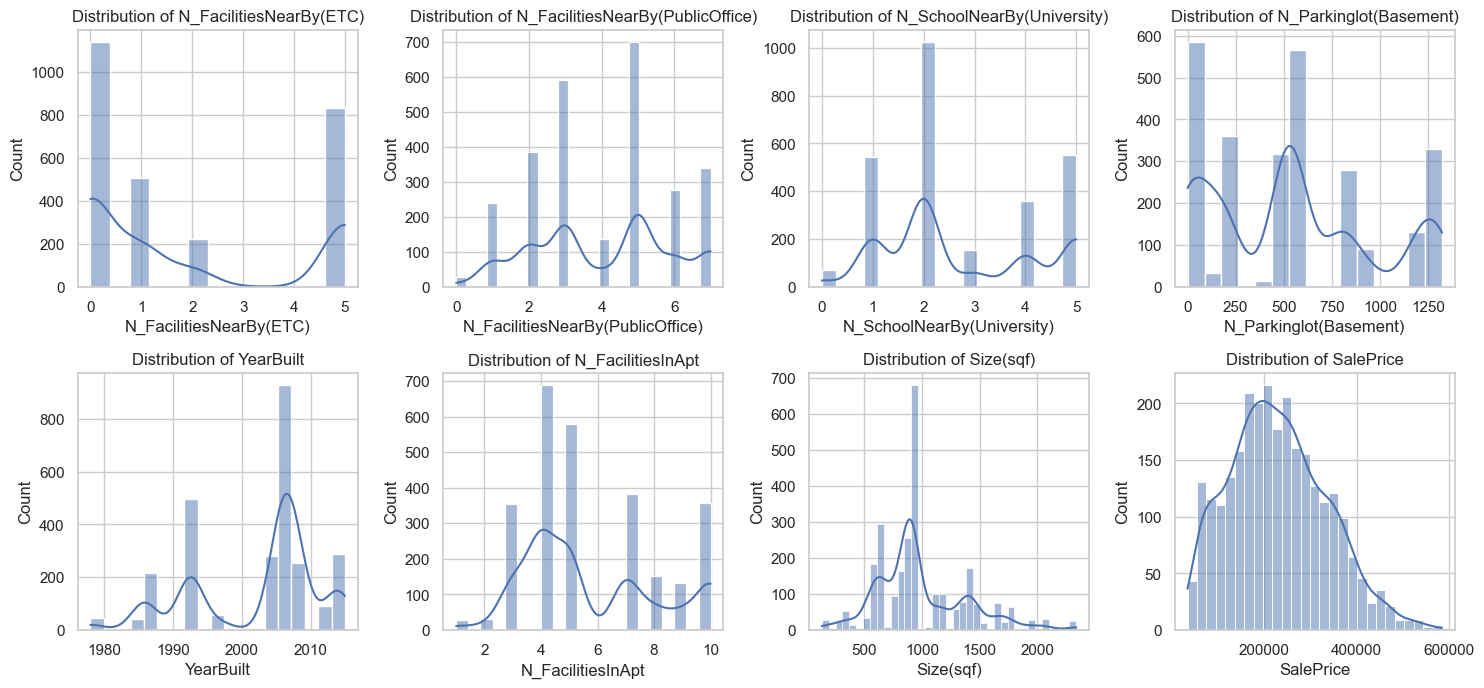

In [345]:
sns.set(style="whitegrid")
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))

# Lopping untuk membuat histplot setiap kolom numerik
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()

Insight: Dari semua fitur tidak fitur yang berdistribusi normal. Pengecekan ini dilakukan untuk menentukan encoding yang sesuai dari setiap fitur pada tahap data preparation

# Data Splitting

In [346]:
X = df.drop(columns = 'SalePrice')
y = df['SalePrice']

In [347]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

In [348]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2160, 10), (541, 10), (2160,), (541,))

# Data Preparation

Penjelasan alasan pemilihan metode preprocessing harus dijelaskan juga! Misalkan untuk Race dan Gender dilakukan OneHot Encoder karena memiliki unique value dibawah 10. dst..

1. HallwayType menggunakan encoding OneHotEncoder karena memiliki unique values dibawah 5
2. SubwayStation menggunakan encoding BinaryEncoder karena memiliki unique values di atas 5
3. TimeToSubway mengunakaan encoding OrdinalEncoder karena unique values memiliki tingkatan/urutan
4. Semua fitur numerik akan di scaller menggunakan Robust Scaller karena berdistribusi tidak normal

In [349]:
# prompt: cara encoding ordinal encoder

# Buat objek OrdinalEncoder
ordinal_encoder = ce.OrdinalEncoder(
    cols=['TimeToSubway'],
    return_df=True,
    mapping=[
        {
            'col': 'TimeToSubway',
            'mapping': {
                '0-5min': 1,
                '5-10min': 2,
                '10-15min': 3,
                '15-20min': 4,
                '20-25min': 5,

            }
        }
    ]
)

# Fit dan transform data
X_train_encoded = ordinal_encoder.fit_transform(X_train)
X_test_encoded = ordinal_encoder.transform(X_test)


In [350]:
ordinal_map=[
    {'col':'TimeToSubway',
     'mapping':{'no_bus_stop_nearby':0,'15min-20min':1,'10min-15min':2,'5min-10min':3,'0-5min':4}}
]


transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop = 'first'), ['HallwayType']),
    ('binary', ce.BinaryEncoder(), ['SubwayStation']),
    ('ordinal', ce.OrdinalEncoder(mapping=ordinal_map,cols='TimeToSubway'), ['TimeToSubway']),
    ('scaler', RobustScaler(), X_train.select_dtypes(include = 'number').columns)
], remainder = 'passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot', OneHotEncoder(drop='first'),
                                 ['HallwayType']),
                                ('binary', BinaryEncoder(), ['SubwayStation']),
                                ('ordinal',
                                 OrdinalEncoder(cols='TimeToSubway',
                                                mapping=[{'col': 'TimeToSubway',
                                                          'data_type': dtype('O'),
                                                          'mapping': no_bus_stop_nearby    0
15min-20min           1
10min-15min           2
5min-10min            3
0-5min                4
dtype: int64}]),
                                 ['TimeToSubway']),
                                ('scaler', RobustScaler(),
                                 Index(['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
       'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
       'N_FacilitiesInApt', 'Size(sqf)'],
      dtype='object'))])

# Modelling

### Rule Based Model (Non ML)

In [351]:
# buat rumus rule based
def rule_based(df):
    if (df['YearBuilt']>1999) and df['TimeToSubway'] == '0-5min':
        return df['Size(sqf)']*270
    elif (df['YearBuilt']<=1999) and df['TimeToSubway'] == '0-5min':
        return df['Size(sqf)']*175
    elif (df['YearBuilt']>1999) and df['TimeToSubway'] == '5-10min':
        return df['Size(sqf)']*265
    elif (df['YearBuilt']<=1999) and df['TimeToSubway'] == '5-10min':
        return df['Size(sqf)']*170
    elif (df['YearBuilt']>1999) and df['TimeToSubway'] == '10-15min':
        return df['Size(sqf)']*260
    elif (df['YearBuilt']<=1999) and df['TimeToSubway'] == '10-15min':
        return df['Size(sqf)']*165
    elif (df['YearBuilt']>1999) and df['TimeToSubway'] == '15-20min':
        return df['Size(sqf)']*235
    elif (df['YearBuilt']<=1999) and df['TimeToSubway'] == '15-20min':
        return df['Size(sqf)']*160
    elif (df['YearBuilt']>1999) and df['TimeToSubway'] == 'no_bus_stop_nearby':
        return df['Size(sqf)']*225
    elif (df['YearBuilt']<=1999) and df['TimeToSubway'] == 'no_bus_stop_nearby':
        return df['Size(sqf)']*140
    else:
        return 0

In [352]:
y_pred_train_rule_based = X_train.apply(rule_based, axis = 1)
train_score_MAE = mean_absolute_error(y_train, y_pred_train_rule_based)
train_score_RMSE = root_mean_squared_error(y_train, y_pred_train_rule_based)
train_score_MAPE = mean_absolute_percentage_error(y_train, y_pred_train_rule_based)

y_pred_test_rule_based = X_test.apply(rule_based, axis = 1)
test_score_MAE = mean_absolute_error(y_test, y_pred_test_rule_based)
test_score_RMSE = root_mean_squared_error(y_test, y_pred_test_rule_based)
test_score_MAPE = mean_absolute_percentage_error(y_test, y_pred_test_rule_based)

In [353]:
df0 = pd.DataFrame({
    'model': ['Rule Based'],
    'train_score_MAE': -train_score_MAE,
    'train_score_RMSE': -train_score_RMSE,
    'train_score_MAPE':- train_score_MAPE,
    'test_score_MAE': -test_score_MAE,
    'test_score_RMSE': -test_score_RMSE,
    'test_score_MAPE': -test_score_MAPE}).sort_values(by = 'test_score_MAE', ascending = True)
df0

,model,train_score_MAE,train_score_RMSE,train_score_MAPE,test_score_MAE,test_score_RMSE,test_score_MAPE
0,Rule Based,-115917.624074,-144189.863933,-0.61569,-113722.678373,-140225.598998,-0.602689


Kalau hanya menggunakan rule based sederhana (Hanya dua fitur) error berdasarkan MAe yang diporelh sebesar 115,917.62

## Experiment 1: Based Model

In [354]:
# base model
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=0)
knn = KNeighborsRegressor()

# Ridge & Lasso
ls=Lasso()
rd=Ridge()

# voting
vc = VotingRegressor([
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
    ])

# stacking
base_model = ([
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
])
meta_model = LinearRegression()
stacking = StackingRegressor(base_model,meta_model)

# bagging
rf = RandomForestRegressor(random_state=0)

# boosting
gb = GradientBoostingRegressor(random_state=0)
xgb = XGBRegressor(random_state=0)

In [355]:
from imblearn.pipeline import Pipeline



train_score_listMAE = []
train_score_listRMSE = []
train_score_listMAPE = []
train_score_std_listMAE = []
test_score_listMAE = []
test_score_listRMSE = []
test_score_listMAPE = []
test_score_std_listMAE = []


for i in [lr, dt, knn, ls, rd, vc, stacking, rf, gb, xgb]:
    model = Pipeline([
        ('transformer', transformer),
        ('model', i)
    ])
    # Train model
    scoreMAE = cross_val_score(model, X_train, y_train, cv = KFold(5), scoring = 'neg_mean_absolute_error')
    scoreRMSE= cross_val_score(model, X_train, y_train, cv = KFold(5), scoring = 'neg_root_mean_squared_error')
    scoreMAPE= cross_val_score(model, X_train, y_train, cv = KFold(5), scoring = 'neg_mean_absolute_percentage_error')

    # menghitung mean MAE, RMSE, MAPE score setiap split
    train_score_listMAE.append(scoreMAE.mean())
    train_score_listRMSE.append(scoreRMSE.mean())
    train_score_listMAPE.append(scoreMAPE.mean())

    # Prediksi
    model.fit(X_train, y_train)
    ypred_test = model.predict(X_test)

    # Evaluasi
    test_scoreMAE = -mean_absolute_error(y_test, ypred_test)
    test_score_listMAE.append(test_scoreMAE)
    test_scoreRMSE = -root_mean_squared_error(y_test, ypred_test)
    test_score_listRMSE.append(test_scoreRMSE)
    test_scoreMAPE = -mean_absolute_percentage_error(y_test, ypred_test)
    test_score_listMAPE.append(test_scoreMAPE)

    # menghitung standar deviasi data train dan test
    train_score_std_listMAE.append(scoreMAE.std())
    test_score_std_listMAE.append(test_scoreMAE.std())


df1 = pd.DataFrame({
    'model': ['Linear Regression', 'Decision Tree', 'KNN', 'Lasso', 'Ridge', 'VC', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'train_score_MAE': train_score_listMAE,
    'train_score_RMSE': train_score_listRMSE,
    'train_score_MAPE': train_score_listMAPE,
    'test_score_MAE': test_score_listMAE,
    'test_score_RMSE': test_score_listRMSE,
    'test_score_MAPE': test_score_listMAPE}).sort_values(by = 'test_score_MAE', ascending = True)
df1

,model,train_score_MAE,train_score_RMSE,train_score_MAPE,test_score_MAE,test_score_RMSE,test_score_MAPE
4,Ridge,-42447.333532,-52439.117412,-0.218997,-43407.956860,-53149.582096,-0.221572
3,Lasso,-42445.620342,-52439.517417,-0.218960,-43393.762923,-53140.924578,-0.221463
0,Linear Regression,-42445.507368,-52439.503669,-0.218961,-43392.725247,-53140.295327,-0.221456
2,KNN,-39436.581574,-49192.310741,-0.208079,-39959.040296,-50517.902546,-0.203473
5,VC,-38264.176914,-46920.640571,-0.198834,-39604.635057,-48663.827567,-0.203252
6,Stacking,-37365.068897,-46105.077611,-0.191264,-39163.285120,-48330.181241,-0.201862
1,Decision Tree,-37278.456930,-46280.930735,-0.190323,-39156.598891,-48567.770869,-0.201903
9,XGBoost,-37294.518150,-46301.220505,-0.190414,-38964.237660,-48008.162307,-0.198805
7,Random Forest,-37277.696136,-46227.714246,-0.190601,-38921.666908,-47998.982001,-0.198852
8,Gradient Boosting,-37050.184520,-45888.891284,-0.190197,-38684.111368,-47575.885175,-0.197414


Insight: dari experimet based model diperoleh Gradient Boosting	 menjadi algoritma terbaik dengan MAE sebesar 38.684 (dalam won)

## Experiment 2: Hapus Outliers

Apakah dengan menghapus outliers dapat meningkatkan performa model

In [356]:
def hapus_outliers(numerik, target):
    variabel_target = target
    for setiap_kolom in numerik.drop(columns = variabel_target).select_dtypes(include='number').columns:
        q3 = numerik[setiap_kolom].quantile(0.75)
        q1 = numerik[setiap_kolom].quantile(0.25)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr

        # pembersihan data dari outliers
        numerik = numerik[(numerik[setiap_kolom] <= upper_bound) & (numerik[setiap_kolom] >= lower_bound)]

    return numerik

In [357]:
df_without_outliers = hapus_outliers(df, 'SalePrice')
df_without_outliers['SalePrice'].value_counts()

SalePrice
265486    21
203539    20
194690    18
230088    18
252212    18
          ..
288053     1
60973      1
438053     1
260707     1
42477      1
Name: count, Length: 813, dtype: int64

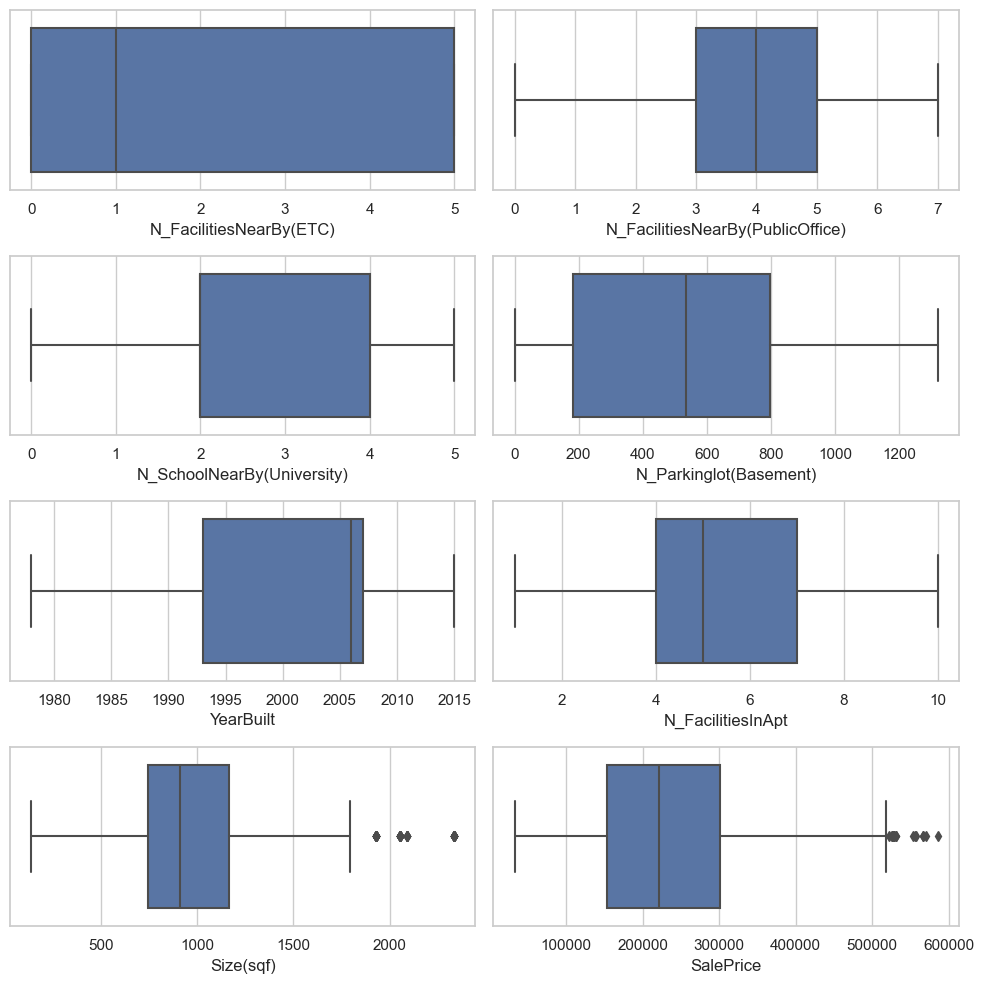

In [358]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

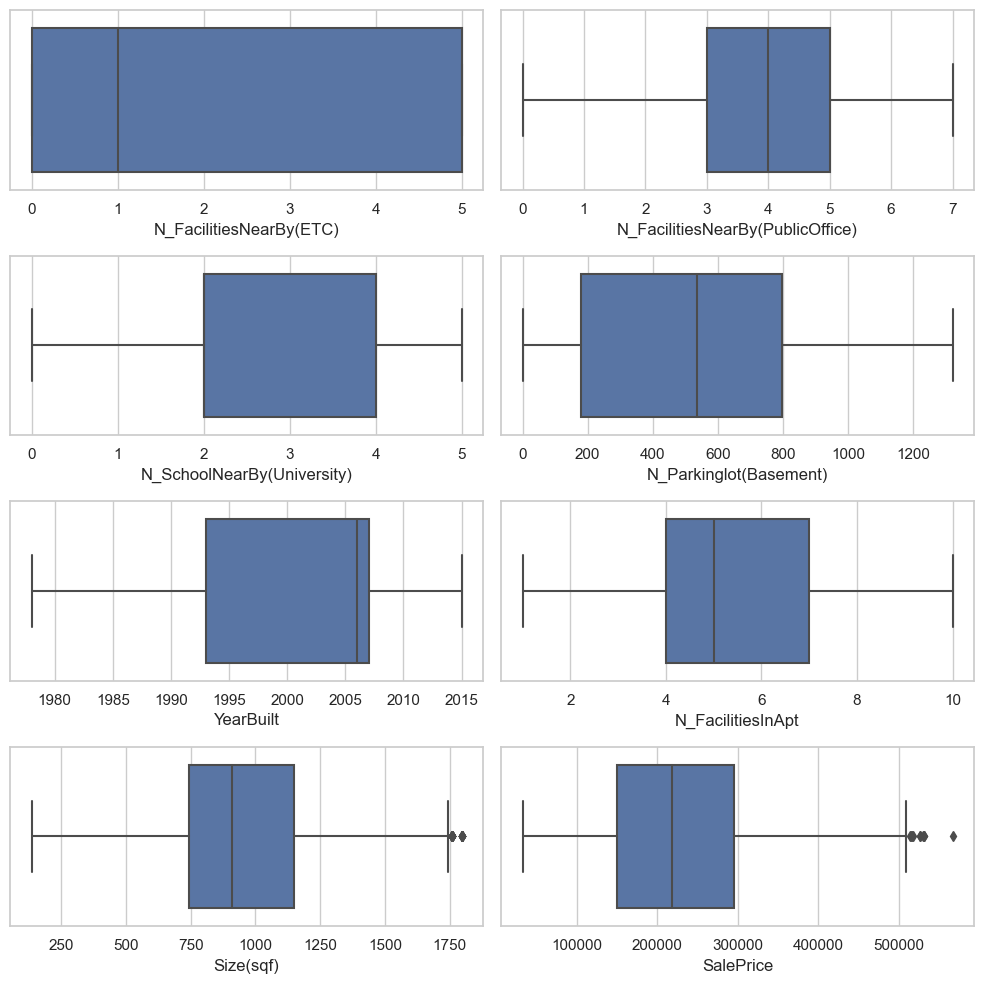

In [359]:
numerik = df_without_outliers.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = df_without_outliers[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

In [360]:
X_no_outliers = df_without_outliers.drop(columns = 'SalePrice')
y_no_outliers = df_without_outliers['SalePrice']
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers,
    y_no_outliers,
    test_size = 0.2,
    random_state = 42
)


In [361]:
X_train_no_outliers.shape, X_test_no_outliers.shape, y_train_no_outliers.shape, y_test_no_outliers.shape

((2093, 10), (524, 10), (2093,), (524,))

In [362]:

train_score_listMAE = []
train_score_listRMSE = []
train_score_listMAPE = []
train_score_std_listMAE = []
test_score_listMAE = []
test_score_listRMSE = []
test_score_listMAPE = []
test_score_std_listMAE = []

for i in [lr, dt, knn, ls, rd, vc, stacking, rf, gb, xgb]:
    model = Pipeline([
        ('transformer', transformer),
        ('model', i)
    ])
    # Train model
    scoreMAE = cross_val_score(model, X_train_no_outliers, y_train_no_outliers, cv = KFold(5), scoring = 'neg_mean_absolute_error')
    scoreRMSE= cross_val_score(model, X_train_no_outliers, y_train_no_outliers, cv = KFold(5), scoring = 'neg_root_mean_squared_error')
    scoreMAPE= cross_val_score(model, X_train_no_outliers, y_train_no_outliers, cv = KFold(5), scoring = 'neg_mean_absolute_percentage_error')

    # menghitung mean MAE, RMSE, MAPE score setiap split
    train_score_listMAE.append(scoreMAE.mean())
    train_score_listRMSE.append(scoreRMSE.mean())
    train_score_listMAPE.append(scoreMAPE.mean())

    # menghitung standar deviasi masing masing metriks
    train_score_std_listMAE.append(scoreMAE.std())


    # Prediksi
    model.fit(X_train_no_outliers, y_train_no_outliers)
    ypred_test_no_outliers = model.predict(X_test_no_outliers)


    test_scoreMAE = -mean_absolute_error(y_test_no_outliers, ypred_test_no_outliers)
    test_score_listMAE.append(test_scoreMAE)
    test_scoreRMSE = -root_mean_squared_error(y_test_no_outliers, ypred_test_no_outliers)
    test_score_listRMSE.append(test_scoreRMSE)
    test_scoreMAPE = -mean_absolute_percentage_error(y_test_no_outliers, ypred_test_no_outliers)
    test_score_listMAPE.append(test_scoreMAPE)
    test_score_std_listMAE.append(test_scoreMAE.std())



In [363]:
df2 = pd.DataFrame({
    'model': ['Linear Regression', 'Decision Tree', 'KNN','Lasso', 'Ridge', 'VC', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'train_score_MAE': train_score_listMAE,
    'train_score_RMSE': train_score_listRMSE,
    'train_score_MAPE': train_score_listMAPE,
    'test_score_MAE': test_score_listMAE,
    'test_score_RMSE': test_score_listRMSE,
    'test_score_MAPE': test_score_listMAPE}).sort_values(by = 'test_score_MAE', ascending = True)

df2

,model,train_score_MAE,train_score_RMSE,train_score_MAPE,test_score_MAE,test_score_RMSE,test_score_MAPE
0,Linear Regression,-41597.357821,-50843.068542,-0.218880,-41269.182379,-51628.374499,-0.208484
3,Lasso,-41597.099218,-50842.508882,-0.218880,-41268.749470,-51627.660707,-0.208480
4,Ridge,-41595.356616,-50838.917921,-0.218855,-41261.599221,-51615.570059,-0.208463
2,KNN,-38529.437699,-48942.715508,-0.202399,-40001.343130,-52534.098540,-0.199130
5,VC,-37916.461197,-46594.149562,-0.200624,-37819.090006,-47651.999316,-0.189212
7,Random Forest,-36985.954693,-46162.311239,-0.196024,-36974.345079,-46461.624953,-0.187792
6,Stacking,-37416.842684,-46226.564980,-0.198571,-36913.448513,-45954.342720,-0.183758
9,XGBoost,-37151.618029,-46426.354024,-0.197451,-36877.353784,-46170.929872,-0.185161
1,Decision Tree,-37155.963023,-46456.309082,-0.197509,-36683.922790,-45885.675219,-0.183054
8,Gradient Boosting,-36773.485497,-45619.254360,-0.194852,-36510.901627,-45662.314169,-0.183755


Insight: Dari experiment diperoleh dengan menghapus outliers model yang dibentuk lebih baik dan ketika di uji ke data testing juga menghasilkan error yang lebih kecil dengan MAE testing 36,510 (dalam won). Oleh karena itu pada experiment selanjutnya diputuskan menggunkan data tanpa outliers

## Experiment 3: Feature without Multikolinieritas

In [364]:
X_VIF = df_without_outliers[['N_FacilitiesNearBy(PublicOffice)','Size(sqf)','N_FacilitiesNearBy(ETC)','N_Parkinglot(Basement)']]
y_VIF = df_without_outliers['SalePrice']

X_train_VIF, X_test_VIF, y_train_VIF, y_test_VIF = train_test_split(
    X_VIF,
    y_VIF,
    test_size = 0.2,
    random_state = 42
)

In [365]:
X_train_VIF.shape, X_test_VIF.shape, y_train_VIF.shape, y_test_VIF.shape

((2093, 4), (524, 4), (2093,), (524,))

In [366]:
transformer_VIF = ColumnTransformer([
    ('scaler', RobustScaler(), X_train_VIF.select_dtypes(include = 'number').columns)
], remainder = 'passthrough')
transformer_VIF

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', RobustScaler(),
                                 Index(['N_FacilitiesNearBy(PublicOffice)', 'Size(sqf)',
       'N_FacilitiesNearBy(ETC)', 'N_Parkinglot(Basement)'],
      dtype='object'))])

In [367]:
train_score_listMAE = []
train_score_listRMSE = []
train_score_listMAPE = []
train_score_std_listMAE = []
test_score_listMAE = []
test_score_listRMSE = []
test_score_listMAPE = []
test_score_std_listMAE = []


for i in [lr, dt, knn, ls, rd, vc, stacking, rf, gb, xgb]:
    model = Pipeline([
        ('transformer', transformer_VIF),
        ('model', i)
    ])
    # Train model
    scoreMAE = cross_val_score(model, X_train_VIF, y_train_VIF, cv = KFold(5), scoring = 'neg_mean_absolute_error')
    scoreRMSE= cross_val_score(model, X_train_VIF, y_train_VIF, cv = KFold(5), scoring = 'neg_root_mean_squared_error')
    scoreMAPE= cross_val_score(model, X_train_VIF, y_train_VIF, cv = KFold(5), scoring = 'neg_mean_absolute_percentage_error')

    # menghitung mean MAE, RMSE, MAPE score setiap split
    train_score_listMAE.append(scoreMAE.mean())
    train_score_listRMSE.append(scoreRMSE.mean())
    train_score_listMAPE.append(scoreMAPE.mean())

    # menghitung standar deviasi masing masing metriks
    train_score_std_listMAE.append(scoreMAE.std())


    # Prediksi
    model.fit(X_train_VIF, y_train_VIF)
    ypred_test_VIF = model.predict(X_test_VIF)

    # Evaluasi
    test_scoreMAE = -mean_absolute_error(y_test_VIF, ypred_test_VIF)
    test_score_listMAE.append(test_scoreMAE)
    test_scoreRMSE = -root_mean_squared_error(y_test_VIF, ypred_test_VIF)
    test_score_listRMSE.append(test_scoreRMSE)
    test_scoreMAPE = -mean_absolute_percentage_error(y_test_VIF, ypred_test_VIF)
    test_score_listMAPE.append(test_scoreMAPE)
    test_score_std_listMAE.append(test_scoreMAE.std())

In [368]:
df3 = pd.DataFrame({
    'model': ['Linear Regression', 'Decision Tree', 'Lasso', 'Ridge', 'KNN', 'VC', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'train_score_MAE': train_score_listMAE,
    'train_score_RMSE': train_score_listRMSE,
    'train_score_MAPE': train_score_listMAPE,
    'test_score_MAE': test_score_listMAE,
    'test_score_RMSE': test_score_listRMSE,
    'test_score_MAPE': test_score_listMAPE}).sort_values(by = 'test_score_MAE', ascending = True)
df3

,model,train_score_MAE,train_score_RMSE,train_score_MAPE,test_score_MAE,test_score_RMSE,test_score_MAPE
4,KNN,-47590.543776,-58718.721143,-0.248955,-46937.612886,-57944.352199,-0.243411
3,Ridge,-47591.333742,-58719.582979,-0.248917,-46933.853756,-57945.658536,-0.243353
0,Linear Regression,-47591.340904,-58719.558777,-0.248917,-46933.725583,-57945.609318,-0.243354
2,Lasso,-38737.296092,-49861.818054,-0.200657,-39463.775573,-52862.943048,-0.208657
5,VC,-39231.757202,-47559.949352,-0.206351,-39409.206368,-49958.282644,-0.207400
1,Decision Tree,-37232.792933,-46494.227136,-0.197707,-38025.124388,-50846.774978,-0.200215
6,Stacking,-37672.880006,-46579.306466,-0.199716,-38021.488162,-50255.441015,-0.200309
9,XGBoost,-37247.728447,-46506.287186,-0.197791,-37989.779409,-50715.959239,-0.199994
8,Gradient Boosting,-37174.215543,-46098.364501,-0.198228,-37831.122891,-49665.625983,-0.199729
7,Random Forest,-37155.936519,-46402.908459,-0.197029,-37825.074385,-50160.473660,-0.198556


Insight: Dari experiment mengeluarkan fitur dengan VIF yang tinggi ternyata  akurasi model yang diperoleh tidak lebih baik dari experiment 1 dan 2. Artinya dalam case ini multikoliniaritas tidak mempunyai pengaruh yang cukup signifikan pada setiap based model. Oleh karena itu akan dilakukan experiment 4 dengan feature selection untuk mencari fitur yang lebih berpengaruh

## Experiment 4: Resampling with Feature Selection

Dari Experiment 1 dan 2 diperoleh bahwa Gradient Boosting	adalah model dengan akurasi terkecil maka dalam experimet ke empat ini akan di lakukan modelling dengan feature selection dengan model Gradient Boosting

### Backward (RFE)

In [369]:
train_score_listMAE = []
train_score_listRMSE = []
train_score_listMAPE = []
train_score_std_listMAE = []
test_score_listMAE = []
test_score_listRMSE = []
test_score_listMAPE = []
test_score_std_listMAE = []

for i in range(1,10):
    pipeline_model = Pipeline([
        ('transformer', transformer),
        ('selector', RFE(estimator=GradientBoostingRegressor(random_state=0), n_features_to_select = i)),
        ('model', GradientBoostingRegressor(random_state=0))
    ])
    pipeline_model.fit(X_train_no_outliers, y_train_no_outliers)

    # memprediksi data train dan test
    y_pred_train_fs2 = pipeline_model.predict(X_train_no_outliers)
    y_pred_test_fs2 = pipeline_model.predict(X_test_no_outliers)

    # evaluasi model
    train_scoreMAE = -mean_absolute_error(y_train_no_outliers, y_pred_train_fs2)
    train_score_listMAE.append(train_scoreMAE)
    train_scoreRMSE = -root_mean_squared_error(y_train_no_outliers, y_pred_train_fs2)
    train_score_listRMSE.append(train_scoreRMSE)
    train_scoreMAPE = -mean_absolute_percentage_error(y_train_no_outliers, y_pred_train_fs2)
    train_score_listMAPE.append(train_scoreMAPE)
    test_scoreMAE = -mean_absolute_error(y_test_no_outliers, y_pred_test_fs2)
    test_score_listMAE.append(test_scoreMAE)
    test_scoreRMSE = -root_mean_squared_error(y_test_no_outliers, y_pred_test_fs2)
    test_score_listRMSE.append(test_scoreRMSE)
    test_scoreMAPE = -mean_absolute_percentage_error(y_test_no_outliers, y_pred_test_fs2)
    test_score_listMAPE.append(test_scoreMAPE)
    train_std_mae = np.std(y_pred_train_fs2)
    train_score_std_listMAE.append(train_std_mae)
    test_std_mae = np.std(y_pred_test_fs2)
    test_score_std_listMAE.append(test_std_mae)


df4 = pd.DataFrame({
    'k': np.arange(1,10),
    'model': ['GB_1Feature','GB_2Feature','GB_3Feature','GB_4Feature','GB_5Feature','GB_6Feature','GB_7Feature','GB_8Feature','GB_9Feature'],
    'train_score_MAE': train_score_listMAE,
    'train_score_RMSE': train_score_listRMSE,
    'train_score_MAPE': train_score_listMAPE,
    'test_score_MAE': test_score_listMAE,
    'test_score_RMSE': test_score_listRMSE,
    'test_score_MAPE': test_score_listMAPE}).sort_values(by = 'test_score_MAE', ascending = True)

df4


,k,model,train_score_MAE,train_score_RMSE,train_score_MAPE,test_score_MAE,test_score_RMSE,test_score_MAPE
0,1,GB_1Feature,-62170.845231,-77295.048888,-0.363164,-62276.436453,-76150.882646,-0.370705
1,2,GB_2Feature,-42964.833309,-52864.175718,-0.224463,-45058.296711,-56998.190124,-0.229258
2,3,GB_3Feature,-36017.067341,-44354.695452,-0.190038,-36913.948215,-46078.962230,-0.184737
3,4,GB_4Feature,-35685.702803,-44077.255876,-0.187676,-36585.832342,-45715.715292,-0.183395
5,6,GB_6Feature,-35470.098825,-43887.645933,-0.186380,-36565.144726,-45715.007745,-0.183673
8,9,GB_9Feature,-35432.532808,-43868.354835,-0.186378,-36549.134486,-45714.190122,-0.183896
7,8,GB_8Feature,-35418.994196,-43836.884430,-0.186063,-36509.008780,-45689.341060,-0.183573
6,7,GB_7Feature,-35376.317477,-43838.539297,-0.185892,-36501.532610,-45699.366385,-0.183535
4,5,GB_5Feature,-35436.757452,-43927.286941,-0.186308,-36455.139526,-45826.484084,-0.184695


In [370]:
#Melihat feature apa saja yang dipilih oleh model
pipeline_model.steps[1][1].get_support()

array([ True,  True, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True])

array([ True,  True, False, False,  True,  True, False,  True, False,
       False,  True,  True,  True,  True])

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

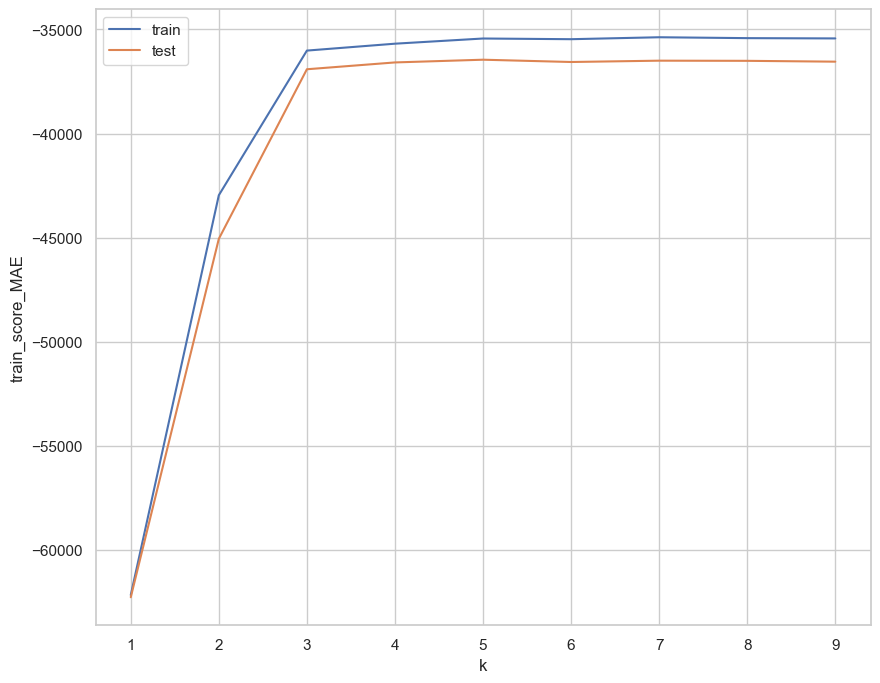

In [371]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
sns.lineplot(data = df4, x = 'k', y = 'train_score_MAE', label = 'train')
sns.lineplot(data = df4, x = 'k', y = 'test_score_MAE', label = 'test')
plt.legend()

Jadi dengan RFE, model akan dikurangi satu persatu fitur yang tidak penting. Dari grafik di atas diperoleh dengan 3 fitur terbaik error yang diperoleh sudah cukup baik. Namun jika dilihat lebih rinci lagi dengan 5 fitur masih ada peningkatan akurasi baik dari data train maupun data test. Oleh karena itu dalam experiment ini diputuskan untuk mengambil 5 fitur terbaik

### SFS

In [372]:
# extract hasil transformer / data preprocessing
X_train_prep = pd.DataFrame(transformer.fit_transform(X_train_no_outliers))
X_train_prep

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,-0.2,-0.5,0.0,1.209076,0.071429,1.666667,-0.092308
1,0.0,1.0,0.0,0.0,1.0,0.0,4.0,-0.2,-1.0,0.0,0.000000,0.071429,-0.333333,1.063736
2,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.8,1.5,1.5,-0.849271,-1.000000,-0.666667,-0.734066
3,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.5,0.0,-0.820097,-1.428571,-0.666667,-0.883516
4,0.0,1.0,0.0,0.0,0.0,1.0,4.0,-0.2,-0.5,0.0,1.209076,0.071429,1.666667,1.048352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.0,1.0,0.0,0.0,1.0,0.0,4.0,-0.2,-2.0,-1.0,-0.520259,0.571429,1.666667,0.008791
2089,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,-0.551053,0.000000,0.000000,0.000000
2090,0.0,0.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,-0.5,-0.495948,0.571429,-1.333333,-1.657143
2091,1.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.8,0.5,1.0,0.444084,-0.071429,0.666667,-0.742857


In [373]:
train_score_listMAE = []
train_score_listRMSE = []
train_score_listMAPE = []
train_score_std_list = []
test_score_listMAE = []
test_score_listRMSE = []
test_score_listMAPE = []
test_score_std_list = []

for i in range(1,10):
    pipeline_model = Pipeline([
        ('transformer', transformer),
        ('selector', SequentialFeatureSelector(estimator=GradientBoostingRegressor(random_state=0), n_features_to_select = i)),
        ('model', gb)
    ])
    pipeline_model.fit(X_train_no_outliers, y_train_no_outliers)

    # memprediksi data train dan test
    y_pred_train_fs2 = pipeline_model.predict(X_train_no_outliers)
    y_pred_test_fs2 = pipeline_model.predict(X_test_no_outliers)

    # evaluasi model
    train_scoreMAE = -mean_absolute_error(y_train_no_outliers, y_pred_train_fs2)
    train_score_listMAE.append(train_scoreMAE)
    train_scoreRMSE = -root_mean_squared_error(y_train_no_outliers, y_pred_train_fs2)
    train_score_listRMSE.append(train_scoreRMSE)
    train_scoreMAPE = -mean_absolute_percentage_error(y_train_no_outliers, y_pred_train_fs2)
    train_score_listMAPE.append(train_scoreMAPE)
    test_scoreMAE = -mean_absolute_error(y_test_no_outliers, y_pred_test_fs2)
    test_score_listMAE.append(test_scoreMAE)
    test_scoreRMSE = -root_mean_squared_error(y_test_no_outliers, y_pred_test_fs2)
    test_score_listRMSE.append(test_scoreRMSE)
    test_scoreMAPE = -mean_absolute_percentage_error(y_test_no_outliers, y_pred_test_fs2)
    test_score_listMAPE.append(test_scoreMAPE)
    train_std = np.std(y_pred_train_fs2)
    train_score_std_list.append(train_std)
    test_std= np.std(y_pred_test_fs2)
    test_score_std_list.append(test_std)


df5 = pd.DataFrame({
    'k': np.arange(1,10),
    'model': ['GB_1Feature','GB_2Feature','GB_3Feature','GB_4Feature','GB_5Feature','GB_6Feature','GB_7Feature','GB_8Feature','GB_9Feature'],
    'train_score_MAE': train_score_listMAE,
    'train_score_RMSE': train_score_listRMSE,
    'train_score_MAPE': train_score_listMAPE,
    'test_score_MAE': test_score_listMAE,
    'test_score_RMSE': test_score_listRMSE,
    'test_score_MAPE': test_score_listMAPE}).sort_values(by = 'test_score_MAE', ascending = True)
df5

,k,model,train_score_MAE,train_score_RMSE,train_score_MAPE,test_score_MAE,test_score_RMSE,test_score_MAPE
0,1,GB_1Feature,-48339.709514,-60455.217702,-0.261990,-50834.869103,-63691.619146,-0.267620
1,2,GB_2Feature,-35828.198753,-44268.577996,-0.189076,-36918.022907,-46244.456935,-0.186208
3,4,GB_4Feature,-35658.689781,-44000.310555,-0.187758,-36882.965376,-46096.868085,-0.184757
2,3,GB_3Feature,-35654.656495,-43958.635806,-0.187813,-36872.636626,-46124.618164,-0.184351
4,5,GB_5Feature,-35611.444478,-43937.607209,-0.187762,-36840.038474,-46070.947136,-0.185039
5,6,GB_6Feature,-35570.729690,-43898.687819,-0.186951,-36832.932131,-46031.631180,-0.184358
6,7,GB_7Feature,-35479.133263,-43850.507199,-0.186565,-36818.012086,-45994.696051,-0.184682
7,8,GB_8Feature,-35434.393914,-43863.287207,-0.186532,-36715.968655,-45868.619800,-0.184315
8,9,GB_9Feature,-35432.327401,-43831.776564,-0.186502,-36685.132987,-45811.088351,-0.183895


In [374]:
  #Melihat feature apa saja yang dipilih oleh model
pipeline_model.steps[1][1].get_support()

array([ True, False,  True,  True,  True, False, False,  True, False,
        True, False,  True,  True,  True])

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

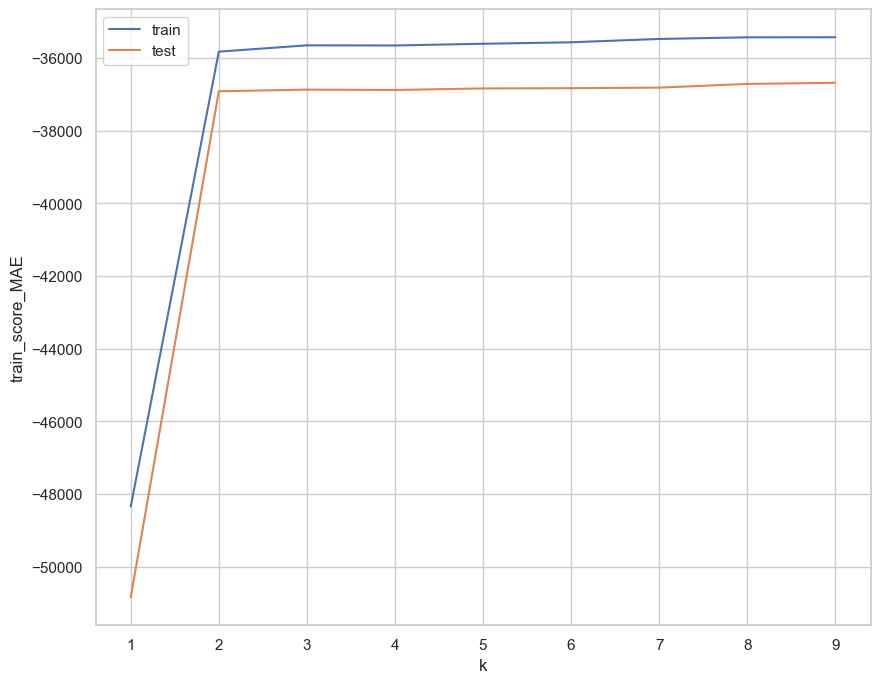

In [375]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
sns.lineplot(data = df5, x = 'k', y = 'train_score_MAE', label = 'train')
sns.lineplot(data = df5, x = 'k', y = 'test_score_MAE', label = 'test')
plt.legend()
plt.show()

Feature Selection dengan metode forward akan memilih satu persatu fitur terbaik yang akan digunakan untuk modelling secara bertahap. Pada lineplot di atas ketika dipilih 2 fitur terbaik memiliki performa cukup tinggi

## Hasil Eksperimen

In [376]:
df0['eksperimen'] = 'Rule Based'
df1['eksperimen'] = 'Based Model'
df2['eksperimen'] = 'Without Outliers'
df3['eksperimen'] = 'Multikolinearitas'
df4['eksperimen'] = 'Resampling with Feature Selection Backward'
df5['eksperimen'] = 'Resampling with Feature Selection SFS'

# penggabungan semua df score
df_gab = pd.concat([df0, df1, df2,df3,df4,df5], axis = 0)
df_gab = df_gab.set_index(['eksperimen','model'])

# highlight ke score terbaik
df_gab.style.highlight_max(subset = ['train_score_MAE','test_score_MAE'],color = 'lightgreen', axis = 0)



train_score_MAE	train_score_RMSE	train_score_MAPE	train_score_stdMAE	train_score_stdRMSE	train_score_stdMAPE

## Final Model

Karena akurasi dengan feature selection RFE lebih baik dari experiment lainnya maka final model yang di pilih adalah gradient boosting dengan 5 fitur terbaik menggunakan feature selection RFE.

In [377]:
best_model = Pipeline([
    ('transformer', transformer),
    ('selector', RFE(estimator=GradientBoostingRegressor(random_state=0), n_features_to_select = 5)),
    ('model', gb)
])

best_model.fit(X_train_no_outliers, y_train_no_outliers)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['HallwayType']),
                                                 ('binary', BinaryEncoder(),
                                                  ['SubwayStation']),
                                                 ('ordinal',
                                                  OrdinalEncoder(cols='TimeToSubway',
                                                                 mapping=[{'col': 'TimeToSubway',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': no_bus_stop_nearby    0
15min-20min           1
10min-15min           2
5min-10min...
                                                 ('scaler', RobustScaler(),
                                                  Index(['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
       'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
       'N_FacilitiesInApt', 'Size(sqf)'],
      dtype='object'))])),
                ('selector',
                 RFE(estimator=GradientBoostingRegressor(random_state=0),
                     n_features_to_select=5)),
                ('model', GradientBoostingRegressor(random_state=0))])

In [378]:
y_pred_no_outliers = best_model.predict(X_test_no_outliers)
print(mean_absolute_error(y_test_no_outliers, y_pred_no_outliers))
print(root_mean_squared_error(y_test_no_outliers, y_pred_no_outliers))


36455.139526385174
45826.48408394272


## Hyperparameter Tuning

Yang dilakukan hyperparameter tuning adalah SATU MODEL TERBAIK dari hasil eksperimen yang dilakukan

In [379]:
# Kedalaman pohon
max_depth = [2,3,5,6]

# Learning rate
learning_rate = [0.1,0.2]

# Jumlah pohon
n_estimators = [100,128,130,135,140]

# Jumlah baris tiap pohon (% dari total baris train set)
subsample = [0.1,0.2]

# Jumlah minimal sample
min_samples_split= [2,4,6]



# Hyperparam space XGboost
hyperparam_space_gb = {
    'model__max_depth': max_depth,
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample,
    'model__min_samples_split': min_samples_split,


}

In [380]:
from sklearn.model_selection import RandomizedSearchCV
# Benchmark model dengan hyperparameter tuning
gb = GradientBoostingRegressor(random_state=0)

# Membuat algorithm chains
pipeline_model = Pipeline([
        ('transformer', transformer),
        ('selector', RFE(estimator=GradientBoostingRegressor(random_state=0), n_features_to_select = 5)),
        ('model', GradientBoostingRegressor(random_state=0))
    ])


crossval = KFold(n_splits=5, shuffle=True, random_state=1)


# Hyperparameter tuning
random_gb = RandomizedSearchCV(
    estimator=pipeline_model,
    param_distributions = hyperparam_space_gb,
    n_iter = 100,
    cv = crossval,
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
    n_jobs = -1,
    refit = 'neg_mean_absolute_error',
    random_state = 1
)

In [381]:
random_gb.fit(X_train_no_outliers, y_train_no_outliers)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['HallwayType']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                                                                               ['SubwayStation']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(cols='TimeToSubway',
                                                                                              mapping=[{'col': 'TimeToSubway',
                                                                                                        'data_...
                                              GradientBoostingRegressor(random_state=0))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.1, 0.2],
                                        'model__max_depth': [2, 3, 5, 6],
                                        'model__min_samples_split': [2, 4, 6],
                                        'model__n_estimators': [100, 128, 130,
                                                                135, 140],
                                        'model__subsample': [0.1, 0.2]},
                   random_state=1, refit='neg_mean_absolute_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error'])

In [382]:
random_gb.best_params_

{'model__subsample': 0.2,
 'model__n_estimators': 128,
 'model__min_samples_split': 4,
 'model__max_depth': 5,
 'model__learning_rate': 0.1}

In [383]:
random_gb.best_score_

-36722.9791113249

Insight: dengan hyperparameter tuning akurasi yang diperoleh tidak jauh lebih baik daripada tanpa menggunakan parameter tunning. Oleh karena itu diputuskan menggunakan model based Gradient Boosting dengan feature seection RFE sebanyak 5 fitur sebagai best model

## Penjelasan Model

Gradient Boosting adalah sebuah teknik yang menggabungkan beberapa model yang lemah (weak model) menjadi sebuah model yang kuat.Model-model lemah ini sering disebut dengan weak learners, dan dapat berupa model regresi i sederhana seperti Decision Tree.Secara matematis, Gradient Boosting mengoptimalkan suatu fungsi objektif dengan mengevaluasi gradient pada setiap titik.

Proses iteratif dalam algoritma Gradient Boosting terdiri dari beberapa tahap, yaitu:
1.	Inisialisasi model: Tahap pertama dalam algoritma Gradient Boosting adalah inisialisasi model. Pada tahap ini, model awal dibuat sebagai model konstan yang merupakan rata-rata atau median dari target variable.
2.	Membuat weak model: Pada tahap ini, weak model dibuat sebagai model yang mampu memprediksi error dari model sebelumnya. Model lemah biasanya berupa decision tree yang dangkal dengan satu atau dua percabangan.
3.	Menghitung residual error: Setelah model lemah dibuat, residual error dihitung sebagai selisih antara nilai prediksi dari model sebelumnya dan nilai asli dari target variable.
4.	Menyusun kembali data training: Pada tahap ini, data training diubah dengan menggunakan residual error sebagai target variable.
5.	Membuat model baru: Pada tahap ini, model baru dibuat dengan memprediksi residual error yang dihasilkan dari model sebelumnya.
6.	Menggabungkan model: Model baru yang dibuat pada tahap sebelumnya digabungkan dengan model sebelumnya untuk membentuk model yang lebih baik.
7.	Iterasi berulang: Tahap-tahap di atas diulang berulang-ulang hingga mencapai kondisi berhenti yang ditentukan, seperti jumlah iterasi yang telah ditentukan atau ketika model tidak mengalami peningkatan yang signifikan lagi.

Setelah iterasi di atas selesai dilakukan, model yang dihasilkan akan digunakan untuk memprediksi nilai target pada data testing yang baru.

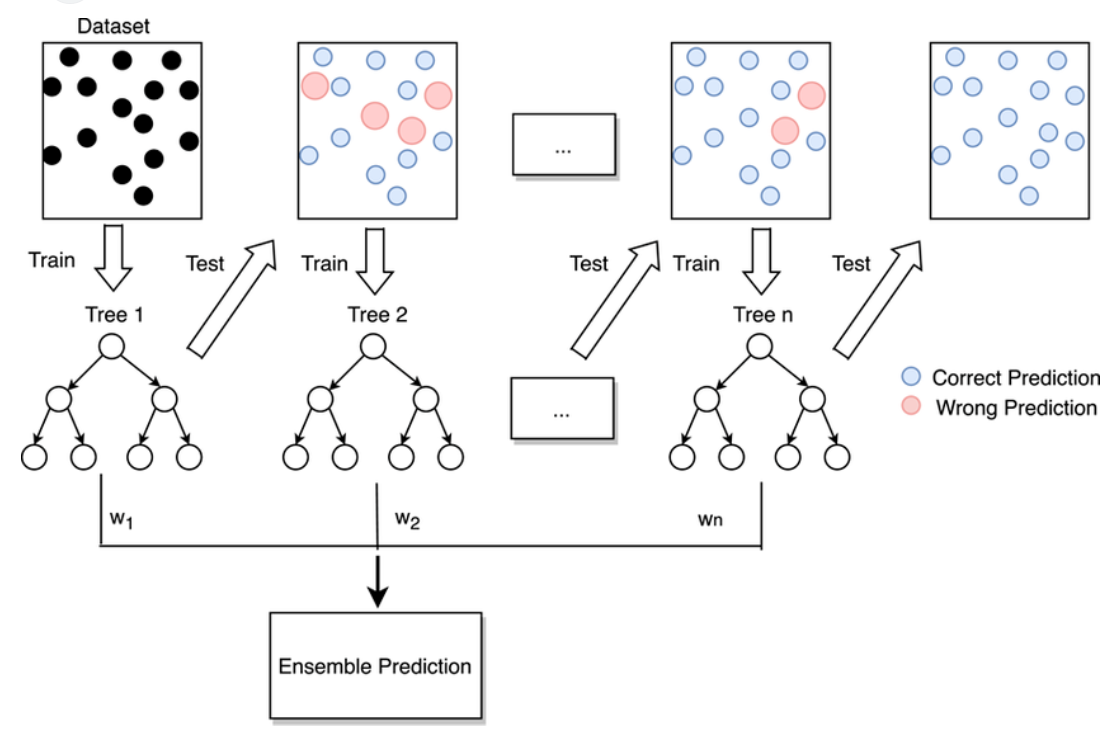

Pada modelling ini dilakukan juga feature selection untuk mencari kombinasi fitur-fitur terbaik menggunakan Recursive Feature Elimination (RFE) . RFE bekerja dengan cara awalnya menggunakan seluruh fitur yang ada lalu mengeluarkan satu per satu fitur yang paling tidak penting dan tetap mempertahankan fitur-fitur yang informatif 
Hal ini dilakukan sampai kriteria tertentu terpenuhi seperti dalam modelling ini dilakukan hingga 10 kombinasi. Berdasarkan hasil iterasi dalam modelling ini diperoleh dengan 5 fitur saja model yang diperoleh sudah cukup baik


# Final Model Interpretation

## Feature Importances

In [384]:
feat_imp = best_model.named_steps['model'].feature_importances_
features = best_model.named_steps['transformer'].get_feature_names_out()

df_feat_imp = pd.DataFrame({
    'features': features[0:5],
    'importance': feat_imp
}).sort_values(by = 'importance', ascending = False)
df_feat_imp

,features,importance
0,one hot__HallwayType_mixed,0.433273
4,binary__SubwayStation_2,0.319807
2,binary__SubwayStation_0,0.107702
3,binary__SubwayStation_1,0.101598
1,one hot__HallwayType_terraced,0.037619


<Axes: xlabel='importance', ylabel='features'>

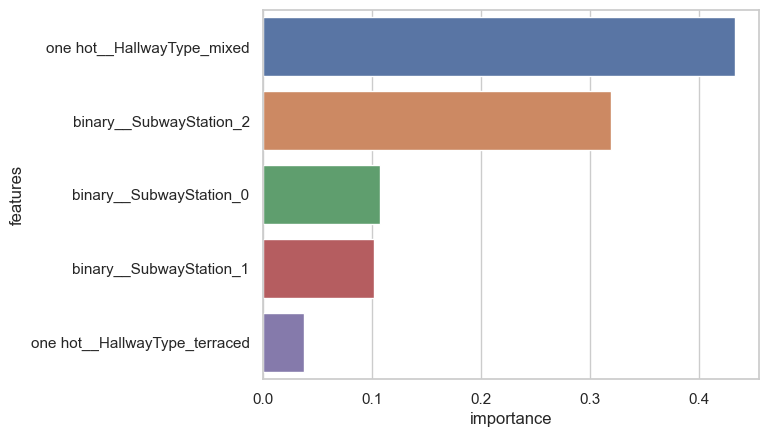

In [385]:
sns.barplot(x = 'importance', y = 'features', data = df_feat_imp)

Berdasarkan barplot feature importances di atas hallway type mixed memiliki pengaruh tertinggi sebesa 0,433 terhadap model di susul dengan subway station 2 sebesar 0,319, subway station 0 sebesar 0,107, subway station 1 sebesar 0,101 dan hallway type terraced sebesar 0,037

## Limitasi

In [389]:
ab=pd.DataFrame(y_pred_no_outliers)
ac=X_test_no_outliers.reset_index(drop=True)
ac['predict']=ab
ac['SalePrice']=y_test_no_outliers.reset_index(drop=True)
ac

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),predict,SalePrice
0,terraced,no_bus_stop_nearby,no_subway_nearby,2.0,2.0,1.0,203.0,2009,5,910,216525.816711,228318
1,terraced,no_bus_stop_nearby,no_subway_nearby,2.0,2.0,1.0,203.0,2009,5,1160,243248.826284,238938
2,terraced,5min~10min,no_subway_nearby,0.0,1.0,1.0,1321.0,2015,10,910,377993.560278,376106
3,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,205818.641257,234513
4,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,252867.160948,253982
...,...,...,...,...,...,...,...,...,...,...,...,...
519,terraced,0-5min,Banwoldang,0.0,2.0,2.0,524.0,2007,4,1366,285941.505617,251327
520,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,207689.684601,274336
521,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,2.0,2.0,184.0,2006,5,636,189115.739747,182300
522,terraced,no_bus_stop_nearby,no_subway_nearby,2.0,2.0,1.0,203.0,2009,5,910,216525.816711,175681


### Cek limitasi Hallway Type

In [390]:
grouped_df = ac.groupby('HallwayType')
mae_by_hallwaytype = grouped_df.apply(lambda group: mean_absolute_error(group['SalePrice'], group['predict']))
print(mae_by_hallwaytype)

HallwayType
corridor    20066.738815
mixed       37820.718969
terraced    39324.410169
dtype: float64


In [312]:
### cek limitasi Hallway Subway Station

In [314]:
grouped_df = ac.groupby('SubwayStation')
mae_by_SubwayStation = grouped_df.apply(lambda group: mean_absolute_error(group['SalePrice'], group['predict']))
print(mae_by_SubwayStation)

SubwayStation
Bangoge                  40672.994013
Banwoldang               33989.969747
Chil-sung-market         25766.760349
Daegu                    19552.720780
Kyungbuk_uni_hospital    46181.117975
Myung-duk                30868.827415
Sin-nam                  38699.004354
no_subway_nearby         24318.294886
dtype: float64


Berikut adalah limitasi pada best model yang diperoleh dengan tresshold menggunakan MAE 40,000 (dalam won)

| Feature | Range |
|---|---|
| SubwayStation| Bangoge, Kyungbuk_uni_hospital |


## Estimasi Keuntungan

Jika hanya menggunakan logika dasar dengan 2 fitur yang diterapkan pada Rule Based Model, maka nilai error (MAE) nya 113.722 won. Sedangkan jika dengan model machine learning maka nilai error nya (MAE) 36.685 won. Sehingga perusahaan dapat mengurangi kesalahan prediksi sebanyak 77,037 won atau sekitar 67,74% dari error MAE pada rule based

## Kesimpulan dan Rekomendasi

### Kesimpulan

1. Model terbaik yang diperoleh selama proses pemodelan untuk memprediksi harga sewa apartemen adalah modwl Gradient Boosting Regression menggunakan feature selection RFE dengan 5 fitur terbaik
2. Hyperparameter tidak digunakan karena hasil akurasi pada Gradient Boosting menggunakan feature selection RFE dengan 5 fitur terbaik masih lebih baik
3. Akurasi nya yang diperoleh dari best model menggunakan MAE 36.685 won
4. Fitur yang paling berpengaruh terhadap harga apartemen di Daegu adalah Hallway Type Mixed
5. Keuntungan nya menggunakan ML sebanyak 77.037 won

### Rekomendasi untuk model

1. Pertimbangkan untuk menambahkan fitur yang memiliki korelasi lebih signifikan dengan harga apartemen, seperti jumlah kamar dalam 1 apartment dan status gedung
2. Terapkan model pembelajaran mesin yang lebih canggih untuk membangun prediksi harga apartemen
3. Pertimbangkan variabel eksternal yang berpotensi memengaruhi harga jual apartemen di Daegu, Korea Selatan ketersediaan kredit dalam pembelian apartemen, suku bunga, Indeks Harga Konsumen (IHK)dan faktor-faktor relevan lainnya.

### Rekomendasi untuk bisnis


1. Hallwaytype dengan type mixed dan corridor memiliki akurasi yang tinggi dalam model. Oleh karena itu perusahaan direkomendasikan untuk menggunakan hasil prediksi model dalam penentuan harga untuk type tersebut
2. Subway Station terdekat seperti Banwoldang, Chilsung Market& Daegu,Myungduk memiliki akurasi yang cukup baik juga. Maka perusahaan direkomendasikan menggunkan hasil prediksi model dalam penentuan harganya
